# Where is the best place to open a cafe in Toronto

# 1. Introduction

## 1.1 Background

As the capital city of Canada, Toronto is a city full of various venues. Although there are millions of different venues exist in each neighbourhood in the city of Toronto, people in each neighbourhood always have a preference for certain type. Therefore, it is adventageous for a new business owner to know which part of Toronto is best to start his/ her new business. For example, where is the best place to open a cafe that will lead to the most customer traffic?

## 1.2 Problem

In a city of Toronto, where is the best place for a new business owner to open the new cafe? This project aims to recommend an area for people to open a new cafe, in which they can attract most customer traffic to the cafe. 

## 1.3 Interest

New cafe owners would be interested in this report. The analysis procedure will also be interesting for new business owners in the city of Toronto, where thet can redo the analysis process to find the most suitable place to open their own business.

# 2. Data

## 2.1 Data Source

Data used in this project was adopted from three main sources:
1. Toronto neighbourhood data are scrapped from a Wikipedia page (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) where it contains Postal Code, Borough, Neighbourhood Name. 
2. Toronto population data are scrapped from Statistics Canada page (https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0) where it contains Postal Code and Population of Canada in 2016. We would assume the popluation proportion will not change a lot until nowadays.
3. Venues data comes from the Foursquare API, where the venues Location, Category, and Rating data will be used to analyze the customer traffic.

## 2.2 Data Usage

Toronto neighbourhood data and population data are scrapped from webpage. Because of some missing data, I will only use the population data in 2016 to represent the population nowadays. For those neighbourhood where a borough is not assigned, the cells will be dropped.
To get the area recommendation, we first need to clean the neighbourhood data and combine it with venues data. By counting the frequence of occurence of cafe in each neighbourhood, we can get the neighbourhoods where cafe are popular. Then, we can combine the population data to the neighbourhood dataframe. By dividing the counts of cafe venues rating by the population at that neighbourhood, we can calculate the average customer traffic for each neighbourhood. The neighbourhood or the borough with the highest average customer traffic will be recommended.  


# 3. Code

## 3.1 Get Data for Toronto

In [4]:
#import necessary library
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from bs4 import BeautifulSoup
import requests

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 3.11 Download Dataset for Neighbourhood and Population

Neighbourhood data comes from the list on Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.
Population data comes from the Canada open data 2016 census, https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&SR=1&S=22&O=A&RPP=9999&PR=0

In [9]:
#get neighbourhood data using pd.read_html
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

In [10]:
#clean "not assigned" borough
toronto_data=df[~df['Borough'].isin(["Not assigned"])].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [11]:
# add latitude and longitude to the dataframe
location_data=pd.read_csv("http://cocl.us/Geospatial_data")
location_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
#merge two dataframe together
new_data=pd.merge(toronto_data,location_data,on='Postal Code')
new_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Work with only boroughs that contain the word Toronto 

In [13]:
# find all the boroughs contain the word "Toronto"
t_data=new_data[new_data['Borough'].str.contains('Toronto')==True].reset_index(drop=True)
t_data.head()#this is the dataframe for Toronto neighbourhood

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = 'QESTMKVTUNWE0ZEWNVF2FINCZ4IZV5BVGVUVGUZLIDN0QKCK' # your Foursquare ID
CLIENT_SECRET = 'ZILR0GCP2IWML3MW4MTK4VHMJ33BMLQE24HXWL3ZW43V15EC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
ACCESS_TOKEN = 'DR4VOEHRB3NBWSSFJ0NEOYB43MNJ1SVDO1DQCXJ4C3J1C0JU' 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QESTMKVTUNWE0ZEWNVF2FINCZ4IZV5BVGVUVGUZLIDN0QKCK
CLIENT_SECRET:ZILR0GCP2IWML3MW4MTK4VHMJ33BMLQE24HXWL3ZW43V15EC


In [15]:
LIMIT=100
radius=500
search_query = 'Coffee Shop'
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
         
        # create the API request URL
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category','Venue ID']
    
    return(nearby_venues)

#### Now, let's get the top 100 venues that are in Toronto Borough within a radius of 500 meters.

In [16]:
t_venues = getNearbyVenues(names=t_data['Neighbourhood'],
                                   latitudes=t_data['Latitude'],
                                   longitudes=t_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [17]:
print(t_venues.shape)
t_venues.head(20)


(1604, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,54ea41ad498e9a11e9e13308
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop,53b8466a498e83df908c3f21
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center,574c229e498ebb5c6b257902
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa,50760559e4b0e8c7babe2497
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant,5612b1cc498e3dd742af0dc8
5,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot,4ae5b91ff964a520a6a121e3
6,"Regent Park, Harbourfront",43.65426,-79.360636,The Extension Room,43.653313,-79.359725,Gym / Fitness Center,4e8b7fa1cc2112f67517660a
7,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site,4ad4c05ef964a520bff620e3
8,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park,51ccc048498ec7792efc955e
9,"Regent Park, Harbourfront",43.65426,-79.360636,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop,4b0978e1f964a520cd1723e3


In [18]:
t_venues=t_venues[t_venues['Venue Category'].str.contains('Coffee Shop')].reset_index(drop=True)
t_venues.head(12)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop,53b8466a498e83df908c3f21
1,"Regent Park, Harbourfront",43.654260,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop,57cd9d20498e6ab8342980e2
2,"Regent Park, Harbourfront",43.654260,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop,51853a73498e4d97a8b20831
3,"Regent Park, Harbourfront",43.654260,-79.360636,Sumach Espresso,43.658135,-79.359515,Coffee Shop,5619551a498e9e35fce2256b
4,"Regent Park, Harbourfront",43.654260,-79.360636,Starbucks,43.651613,-79.364917,Coffee Shop,58c7fbf7424f9373e6427e99
5,"Regent Park, Harbourfront",43.654260,-79.360636,Dark Horse Espresso Bar,43.653081,-79.357078,Coffee Shop,581258b738fa5bbefe4c0857
6,"Regent Park, Harbourfront",43.654260,-79.360636,Savoury Grounds,43.656821,-79.358970,Coffee Shop,4b2cf78cf964a52077cb24e3
7,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,NEO COFFEE BAR,43.660130,-79.385830,Coffee Shop,5db70a0c306d6b000861ac9f
8,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Starbucks,43.658204,-79.388998,Coffee Shop,4aeb5014f964a520c7c021e3
9,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Tim Hortons,43.661038,-79.393797,Coffee Shop,4bc0c71b74a9a5935fa6d0f6


In [19]:
#let's see how many coffee shops are there in each neighbourhood
t_venues['Number of Coffee Shops'] = t_venues.groupby('Neighborhood')['Neighborhood'].transform('count')
t_venues=t_venues.rename(columns={'Neighborhood':'Neighbourhood'})
t_venues.head()

,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID,Number of Coffee Shops
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop,53b8466a498e83df908c3f21,7
1,"Regent Park, Harbourfront",43.65426,-79.360636,Arvo,43.649963,-79.361442,Coffee Shop,57cd9d20498e6ab8342980e2,7
2,"Regent Park, Harbourfront",43.65426,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop,51853a73498e4d97a8b20831,7
3,"Regent Park, Harbourfront",43.65426,-79.360636,Sumach Espresso,43.658135,-79.359515,Coffee Shop,5619551a498e9e35fce2256b,7
4,"Regent Park, Harbourfront",43.65426,-79.360636,Starbucks,43.651613,-79.364917,Coffee Shop,58c7fbf7424f9373e6427e99,7


In [20]:
t1=t_venues.groupby('Neighbourhood').count()[['Number of Coffee Shops']]
t1.head()

,Number of Coffee Shops
Neighbourhood,
Berczy Park,5
"Brockton, Parkdale Village, Exhibition Place",2
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1
Central Bay Street,11
Christie,1


In [21]:
#get table for neighborhood with the most coffee shops
t2=pd.merge(t_data,t1,on='Neighbourhood').sort_values(by='Number of Coffee Shops',ascending=False)
t2=t2.reset_index(drop=True)
t2.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Number of Coffee Shops
0,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,13
1,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,13
2,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,11
3,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,11
4,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,11
5,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,10
6,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,9
7,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,9
8,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7
9,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,6


In [22]:
# visualize the # of coffee shops in the neighbourhood
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

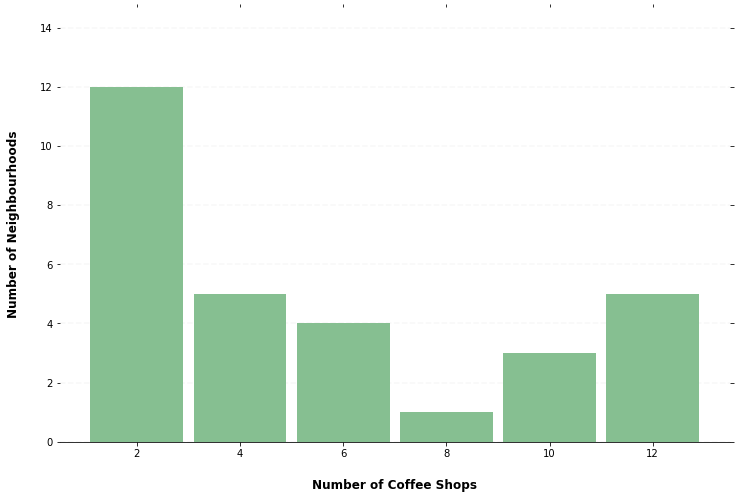

In [23]:
ax = t2.hist(column='Number of Coffee Shops', bins=6, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Number of Coffee Shops", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of Neighbourhoods", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

get the average number of likes for each coffee shop

In [25]:
likes_list=[]
for i in t_venues['Venue ID']:
    venue_id=i
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    results = requests.get(url).json()["response"]['venue']['likes']['count']
    likes_list.append([i,results])
        

In [27]:
likes = pd.DataFrame(likes_list,columns=['Venue ID','Count of Likes'])
likes.head()

,Venue ID,Count of Likes
0,53b8466a498e83df908c3f21,49
1,57cd9d20498e6ab8342980e2,59
2,51853a73498e4d97a8b20831,238
3,5619551a498e9e35fce2256b,19
4,58c7fbf7424f9373e6427e99,16


In [32]:
t3=pd.merge(t_venues,likes,on='Venue ID')
t4=t3.groupby('Neighbourhood').mean()[['Count of Likes']].sort_values(by='Count of Likes',ascending=False).reset_index(drop=False)
t4.head()

,Neighbourhood,Count of Likes
0,St. James Town,116.076923
1,"Kensington Market, Chinatown, Grange Park",104.750000
2,Studio District,90.333333
3,Stn A PO Boxes,61.371429
4,"Little Portugal, Trinity",58.000000


In [36]:
# does more coffee shop means more popular? may not be
t5=pd.merge(t2,t4,on="Neighbourhood")
t5=t5.rename(columns={'Count of Likes':'Avg Number of Likes'})
t5=t5.sort_values(by='Avg Number of Likes',ascending=False)
t5.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
9,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,6,116.076923
13,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,4,104.750000
15,M4M,East Toronto,Studio District,43.659526,-79.340923,3,90.333333
2,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,11,61.371429
21,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2,58.000000
8,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,7,57.857143
5,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,10,56.307692
0,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,13,52.382979
3,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,11,52.200000
29,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,1,48.000000


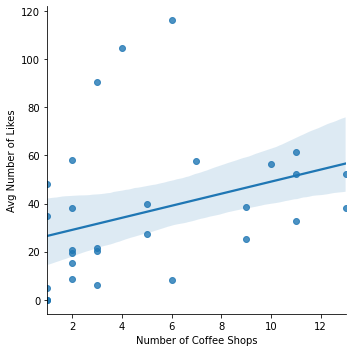

In [37]:
#let's see whether the number of coffee shops has a relationship with avg number of likes
import seaborn as sns
sns.lmplot(x='Number of Coffee Shops',y='Avg Number of Likes',data=t5,fit_reg=True) 

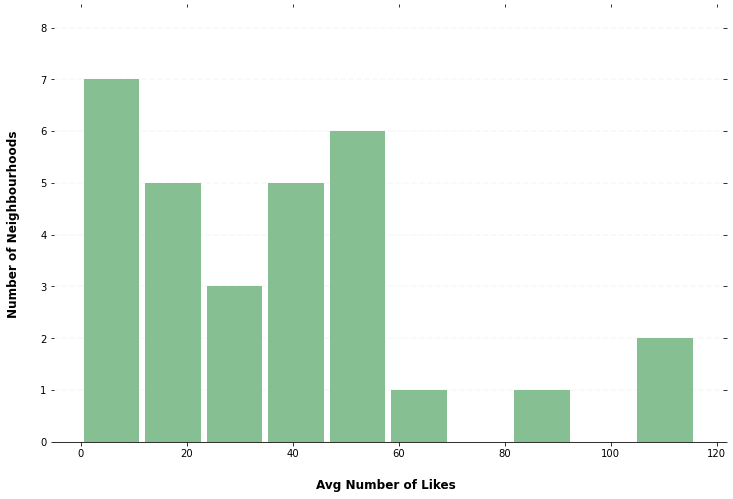

In [39]:
ax = t5.hist(column='Avg Number of Likes', bins=10, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Avg Number of Likes ", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Number of Neighbourhoods", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

In [41]:
# seems no obvious relationship between the number of coffee shops and likes, see clusters
# set number of clusters
kclusters = 5

t_clustering = t5[['Number of Coffee Shops','Avg Number of Likes']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(t_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [43]:
# add clustering labels
t5.insert(0, 'Cluster Labels', kmeans.labels_)

ValueError: cannot insert Cluster Labels, already exists

In [50]:
t5.set_index('Neighbourhood')
t5=t5.reset_index(drop=False)
t5.head()

,index,Cluster Labels,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
0,9,1,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,6,116.076923
1,13,1,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,4,104.750000
2,15,1,M4M,East Toronto,Studio District,43.659526,-79.340923,3,90.333333
3,2,3,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,11,61.371429
4,21,3,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2,58.000000


In [51]:
#define the map location Toronto
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="t_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(t5['Latitude'], t5['Longitude'], t5['Neighbourhood'], t5['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

### cluster 1 

In [53]:
t5.loc[t5['Cluster Labels'] == 0, t5.columns[[1] + list(range(5, t5.shape[1]))]]

,Cluster Labels,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
10,0,43.665860,-79.383160,5,40.000000
11,0,43.657162,-79.378937,9,38.454545
12,0,43.640816,-79.381752,13,38.250000
13,0,43.636847,-79.428191,2,38.000000
14,0,43.669542,-79.422564,1,35.000000
15,0,43.657952,-79.387383,11,32.785714


In [54]:
t5.loc[t5['Cluster Labels'] == 1, t5.columns[[1] + list(range(5, t5.shape[1]))]]

,Cluster Labels,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
0,1,43.651494,-79.375418,6,116.076923
1,1,43.653206,-79.400049,4,104.750000
2,1,43.659526,-79.340923,3,90.333333


In [55]:
t5.loc[t5['Cluster Labels'] == 2, t5.columns[[1] + list(range(5, t5.shape[1]))]]

,Cluster Labels,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
16,2,43.644771,-79.373306,5,27.200000
17,2,43.650571,-79.384568,9,25.423077
18,2,43.667967,-79.367675,3,21.333333
19,2,43.704324,-79.388790,2,20.500000
20,2,43.679557,-79.352188,3,20.333333
21,2,43.715383,-79.405678,2,19.500000
22,2,43.672710,-79.405678,2,15.500000


In [56]:
t5.loc[t5['Cluster Labels'] == 3, t5.columns[[1] + list(range(5, t5.shape[1]))]]

,Cluster Labels,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
3,3,43.646435,-79.374846,11,61.371429
4,3,43.647927,-79.419750,2,58.000000
5,3,43.654260,-79.360636,7,57.857143
6,3,43.648429,-79.382280,10,56.307692
7,3,43.648198,-79.379817,13,52.382979
8,3,43.647177,-79.381576,11,52.200000
9,3,43.648960,-79.456325,1,48.000000


In [57]:
t5.loc[t5['Cluster Labels'] == 4, t5.columns[[1] + list(range(5, t5.shape[1]))]]

,Cluster Labels,Latitude,Longitude,Number of Coffee Shops,Avg Number of Likes
23,4,43.686412,-79.400049,2,8.500000
24,4,43.662301,-79.389494,6,8.142857
25,4,43.651571,-79.484450,3,6.000000
26,4,43.662696,-79.400049,1,5.000000
27,4,43.676357,-79.293031,1,0.000000
28,4,43.628947,-79.394420,1,0.000000
29,4,43.668999,-79.315572,1,0.000000


seems cluster 1 and cluster 3 are more favorable. 